# Evaluating the *SOM* + *Hierarchical Clustering* of the `penguins` dataset

Predictions are plotted next to the ground truth `species` labels.

Besides the visual inspection, the following metrics were used to assess the performance of clustering:

- *Homogeneity*
- *Completeness*
- *V-measure*,

along with creating a mapping from the cluster ids to the class labels and calculating:

- *Accuracy*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
X_scaled = pd.read_csv("../../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
target = pd.read_csv("../../datasets/penguins/simple/y.csv", index_col=0, header=0)

In [4]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(target['species'].to_numpy())

In [5]:
df_pred = pd.read_csv("../predictions/03_01_som_clustering_predictions.csv", header=0, index_col=0)
y_pred = df_pred['cluster_id'].to_numpy()

In [6]:
def visualize_clustering_with_ground_truth(X, y_hat, y, f1='bill_length_mm', f2='bill_depth_mm', figsize=(12, 5), hide_suptitle=False):
	_clustering_result = y_hat.copy()
	_clustering_ids = np.unique(_clustering_result)
	_species_ids = np.unique(y)

	fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

	F1 = X.loc[:, f1]
	F2 = X.loc[:, f2]

	# Predictions

	cmap = plt.cm.tab10
	colors = cmap(_clustering_result)

	ax = axes[0]

	ax.scatter(F1, F2, s=50, edgecolor=colors, color="none", alpha=.9)
	ax.set_title(f"View from\n\"{f2}\" over \"{f1}\"")
	ax.set_xlabel(f1)
	ax.set_ylabel(f2)

	# legend
	handles = [
		plt.Line2D([], [], marker='o', linestyle='', label=f'Cluster {i}', color=cmap(i))
		for i in _clustering_ids
	]
	ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.90))

	# 2. Ground truth

	cmap = plt.cm.Accent_r
	colors = cmap(y)

	ax = axes[1]
	
	ax.scatter(F1, F2, s=50, edgecolor=colors, color="none", alpha=.9)
	ax.set_title(f"View from\n\"{f2}\" over \"{f1}\"")
	ax.set_xlabel(f1)
	ax.set_ylabel(f2)

	# legend
	handles = [
		plt.Line2D([], [], marker='o', linestyle='', label=target_encoder.inverse_transform([i])[0], color=cmap(i))
		for i in _species_ids
	]
	ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.90))

	for ax in axes:
		ax.set_aspect("equal")

	if not hide_suptitle:
		plt.suptitle("SOM predictions vs. Ground truth")

	plt.tight_layout()
	plt.show()

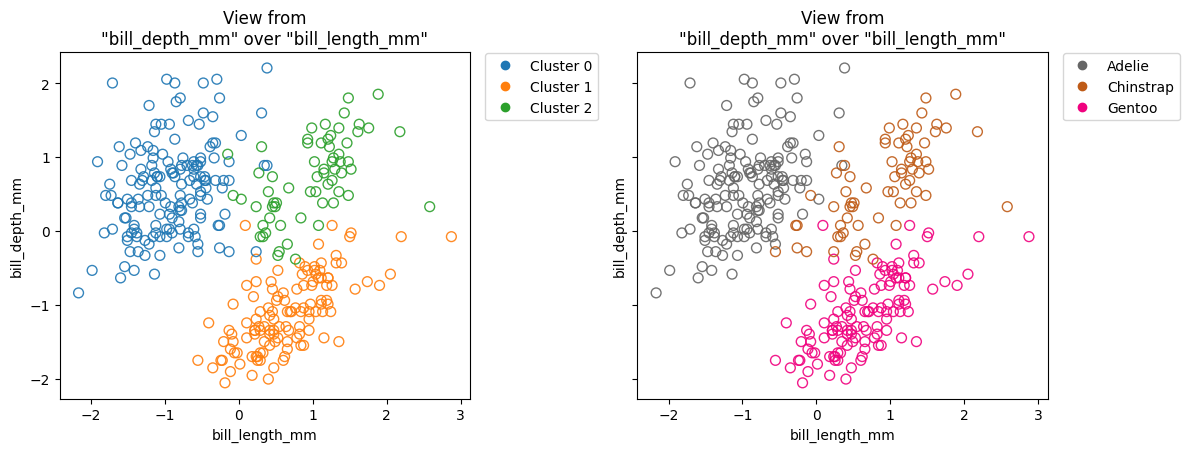

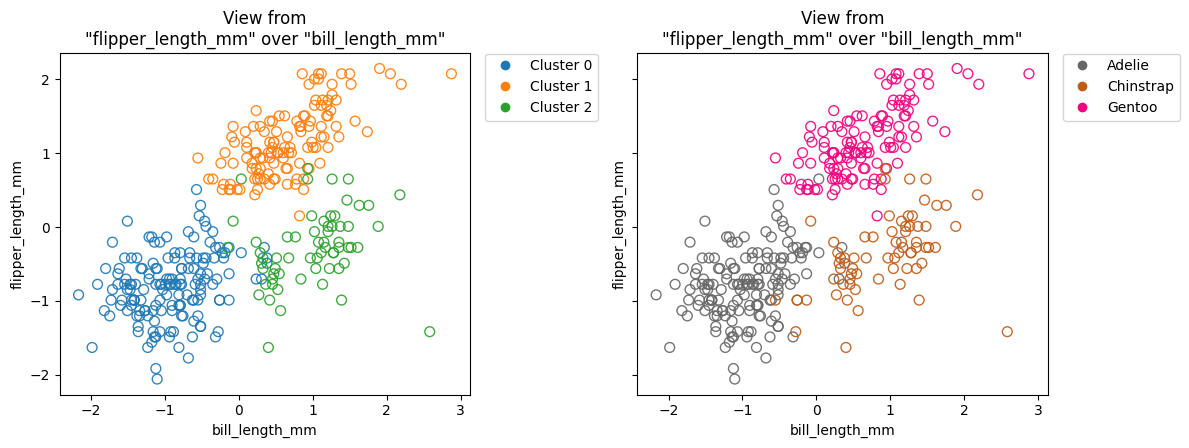

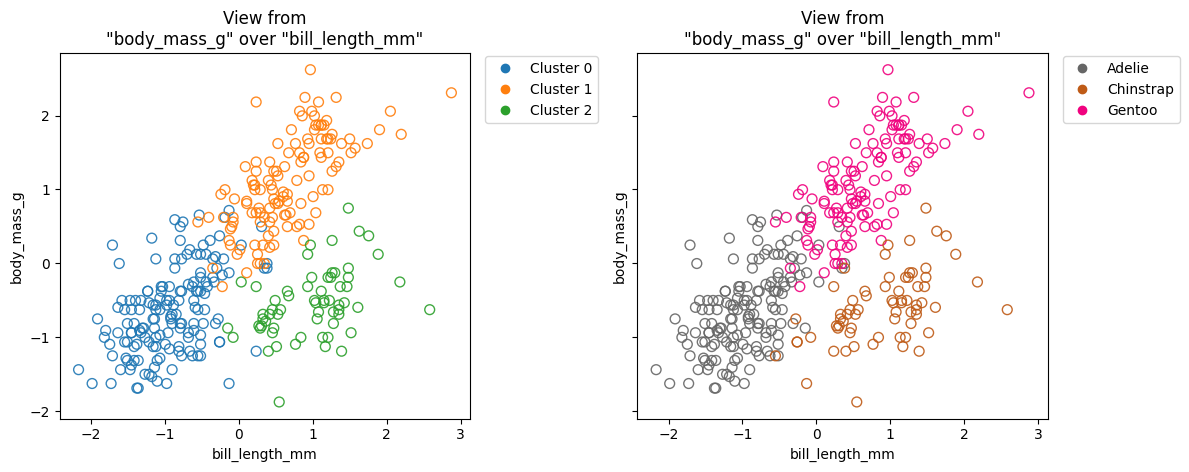

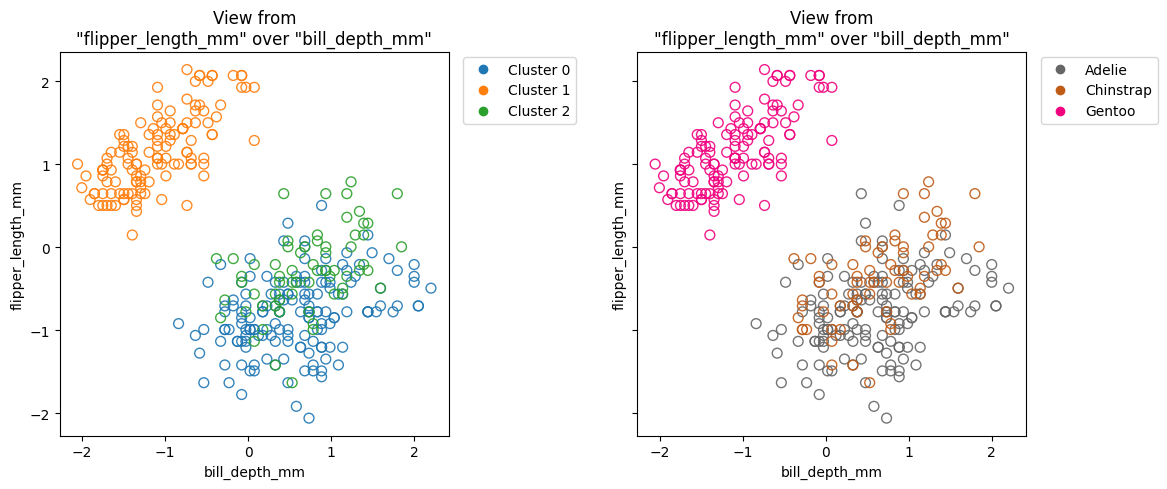

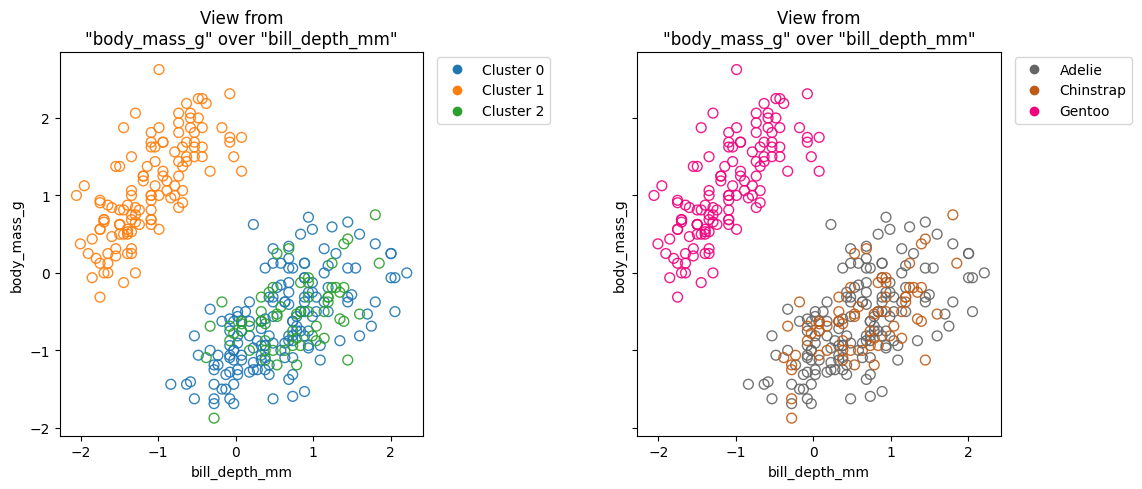

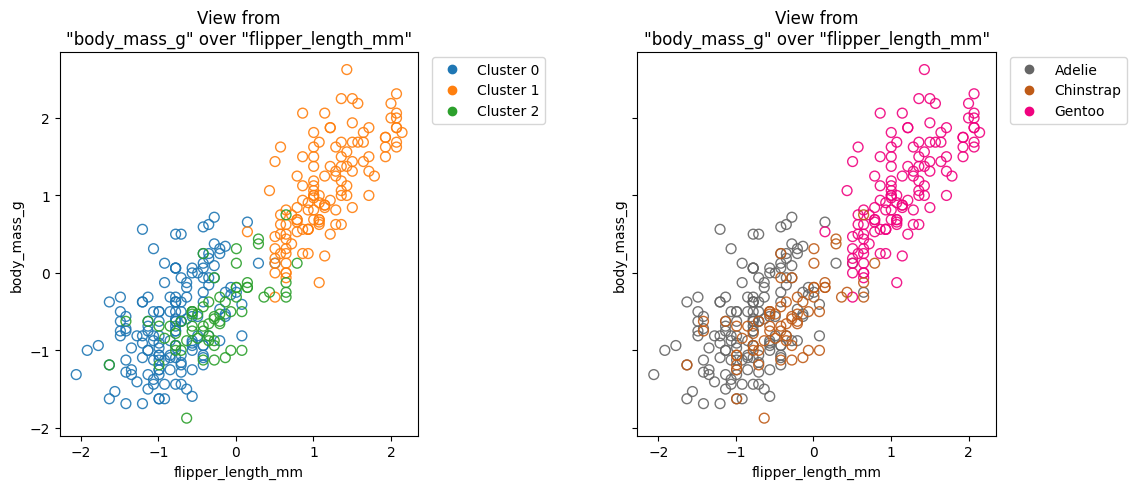

In [7]:
from itertools import combinations

for f1, f2 in combinations(X_scaled.columns, 2):
	visualize_clustering_with_ground_truth(X_scaled, y_pred, y, f1, f2, hide_suptitle=True)

In [8]:
from sklearn.metrics import homogeneity_completeness_v_measure, accuracy_score, silhouette_score

mapper = {
    0: 0,
    1: 2,
    2: 1,
}
y_pred_mapped = np.vectorize(mapper.get)(y_pred.copy())

sil = silhouette_score(X_scaled, y_pred, metric="euclidean")
hcvm = homogeneity_completeness_v_measure(y, y_pred)
acc = accuracy_score(y, y_pred_mapped)

df_performance = pd.Series(np.hstack((sil, hcvm, acc)), index=['Silhouette score', 'Homogeneity', 'Completeness', 'V-measure', 'Accuracy'], name="value")
df_performance.to_frame() \
    .style.format(precision=3)

,value
Silhouette score,0.454
Homogeneity,0.896
Completeness,0.906
V-measure,0.901
Accuracy,0.974
